**Beijing PM2.5 Dataset** --> https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv

**Data Set Information:**

The data time period is between Jan 1st, 2010 to Dec 31st, 2014. Missing data are denoted as "NA".


**Attribute Information:**

No: row number </br>
year: year of data in this row </br>
month: month of data in this row </br>
day: day of data in this row </br>
hour: hour of data in this row </br>
pm2.5: PM2.5 concentration (ug/m^3) </br>
DEWP: Dew Point (â„ƒ) </br>
TEMP: Temperature (â„ƒ) </br>
PRES: Pressure (hPa) </br>
cbwd: Combined wind direction </br>
Iws: Cumulated wind speed (m/s) </br>
Is: Cumulated hours of snow </br>
Ir: Cumulated hours of rain </br>

- **Problem Definition** - The Dataset consists of continuous weather data from Beijing from 2010 to 2014. This is a Multivariate Time Series problem and the goal of this Project is to forecast future values of the weather data from past dataset.
- **Gathering Information** - The dataset is available and can be downloaded from [here](https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv).
- **Exploratory Analysis** - Data Cleaning and EDA have been performed on all the variables and observations have been noted in the EDA section below.
- **Building Models** - Couple of techniques have been tried in this project to get a good forecasting system, including Vector Auto Regressive (VAR), LSTM and Prophet.
- **Evaluation Metric** - In this Project, Root Mean Square Error (RMSE) has been used to evaluate model forecast.



In [ ]:
! pip install fbprophet
! pip install pandas==0.20.2
! pip install pandas --upgrade

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import random

import statsmodels.api as sm

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error

# import Keras
# from keras.preprocessing.sequence import TimeseriesGenerator
# from keras.models import Sequential
# from keras.layers import Dense, LSTM
# Import Prophet
from fbprophet import Prophet
# Import VAR Model
from statsmodels.tsa.vector_ar.var_model import VAR

import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'fbprophet'

In [0]:
# !wget "https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv" -O "/content/gdrive/My Drive/Colab Notebooks/Time Series/PM25_data.csv"

# Data Exploration

In [0]:
df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Time Series/PM25_data.csv")
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [0]:
df['date'] = df[['year', 'month', 'day', 'hour']].apply(lambda row: f"{row['year']}-{row['month']}-{row['day']} {row['hour']}:00:00", axis=1)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,date
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0,2010-01-01 00:00:00
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0,2010-01-01 01:00:00
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0,2010-01-01 02:00:00
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0,2010-01-01 03:00:00
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0,2010-01-01 04:00:00


In [0]:
df.drop(['No','year','month','day','hour'], axis=1, inplace=True)
df.head()

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,date
0,NaN,-21,-11.0,1021.0,NW,1.79,0,0,2010-01-01 00:00:00
1,NaN,-21,-12.0,1020.0,NW,4.92,0,0,2010-01-01 01:00:00
2,NaN,-21,-11.0,1019.0,NW,6.71,0,0,2010-01-01 02:00:00
3,NaN,-21,-14.0,1019.0,NW,9.84,0,0,2010-01-01 03:00:00
4,NaN,-20,-12.0,1018.0,NW,12.97,0,0,2010-01-01 04:00:00


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 9 columns):
pm2.5    41757 non-null float64
DEWP     43824 non-null int64
TEMP     43824 non-null float64
PRES     43824 non-null float64
cbwd     43824 non-null object
Iws      43824 non-null float64
Is       43824 non-null int64
Ir       43824 non-null int64
date     43824 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(3), object(1)
memory usage: 3.0+ MB


In [0]:
df.describe()

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
count,41757.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000
mean,98.613215,1.817246,12.448521,1016.447654,23.889140,0.052734,0.194916
std,92.050387,14.433440,12.198613,10.268698,50.010635,0.760375,1.415867
min,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,29.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,72.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,137.000000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


In [0]:
df.sort_values(by='date', inplace=True)
df.head()

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,date
0,NaN,-21,-11.0,1021.0,NW,1.79,0,0,2010-01-01 00:00:00
1,NaN,-21,-12.0,1020.0,NW,4.92,0,0,2010-01-01 01:00:00
2,NaN,-21,-11.0,1019.0,NW,6.71,0,0,2010-01-01 02:00:00
3,NaN,-21,-14.0,1019.0,NW,9.84,0,0,2010-01-01 03:00:00
4,NaN,-20,-12.0,1018.0,NW,12.97,0,0,2010-01-01 04:00:00


In [0]:
df['date'].min(), df['date'].max()

(Timestamp('2010-01-01 00:00:00'), Timestamp('2014-12-31 23:00:00'))

In [0]:
df.set_index('date', inplace=True)
df.head()

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
date,,,,,,,,
2010-01-01 00:00:00,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [0]:
df.isnull().sum()

pm2.5    2067
DEWP        0
TEMP        0
PRES        0
cbwd        0
Iws         0
Is          0
Ir          0
dtype: int64

In [0]:
df.ix[np.min(np.where(pd.notna(df['pm2.5'])))]

pm2.5     129
DEWP      -16
TEMP       -4
PRES     1020
cbwd       SE
Iws      1.79
Is          0
Ir          0
Name: 2010-01-02 00:00:00, dtype: object

- 2nd January, 2010 was the 1st day when PM2.5 was recorded.

In [0]:
# Data grouped Month-wise
grpd_df = df.resample('MS').mean()
print(grpd_df.shape)
grpd_df.head()

(60, 7)


,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
date,,,,,,,
2010-01-01,90.442573,-17.013441,-6.162634,1028.009409,41.227325,0.479839,0.000000
2010-02-01,97.233979,-13.156250,-1.922619,1023.776786,13.466786,0.132440,0.000000
2010-03-01,94.100141,-7.955645,3.293011,1021.811828,23.281237,0.239247,0.205645
2010-04-01,80.029248,-3.330556,10.806944,1017.169444,58.280833,0.000000,0.252778
2010-05-01,86.899593,7.651882,20.831989,1007.896505,21.419126,0.000000,0.534946


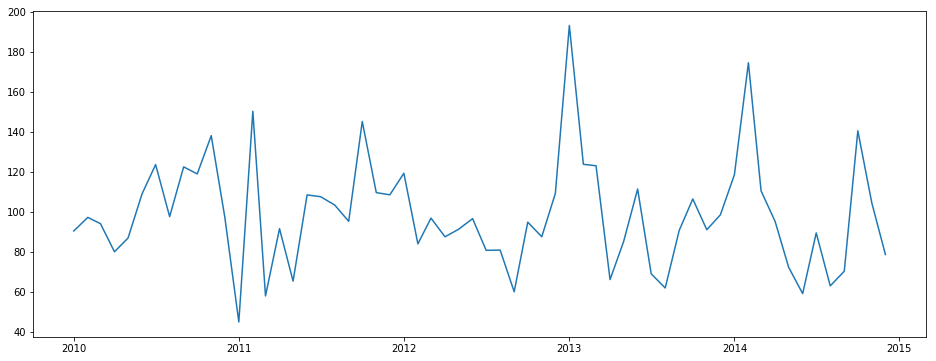

In [0]:
plt.figure(figsize=(16,6))
plt.plot(grpd_df['pm2.5'].dropna())
plt.show()

- From the figure above, it can be seen that there is some kind of Seasonality - PM2.5 peaks at the beginning of next year, then drops to a minimum, then there are a few spikes and finally tends towards peaking by the end of the year.

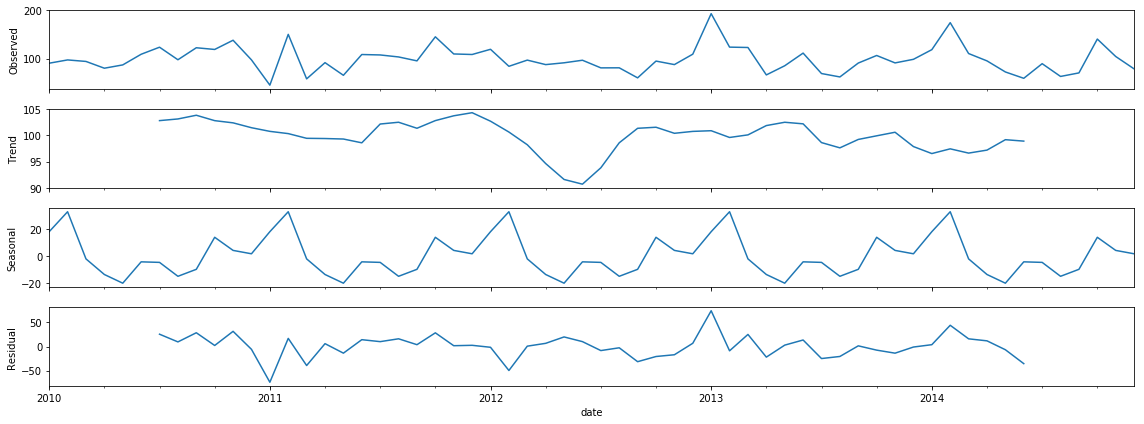

<Figure size 1152x432 with 0 Axes>

In [0]:
from pylab import rcParams
rcParams['figure.figsize'] = 16, 6

# Decomposing the data to check for Trends, Seasonality and Noise.
decomposition = sm.tsa.seasonal_decompose(grpd_df['pm2.5'])
fig = decomposition.plot()
plt.figure(figsize=(16,6))
plt.show()

- There's Seasonality in the PM2.5 data. From the Trend, there was a dip in PM2.5 towards the mid of 2012. However, the Trend since then has been howevering near 100.

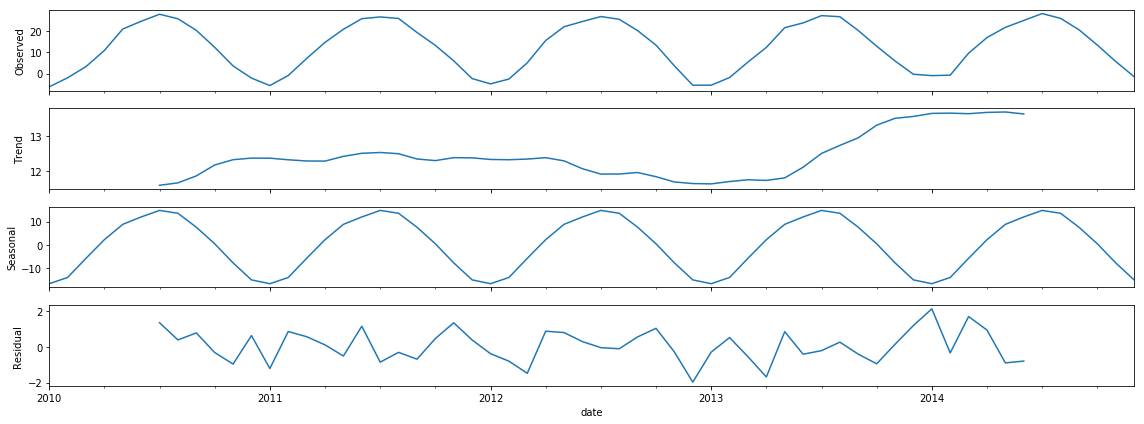

In [0]:
# Decomposing the data to check for Trends, Seasonality and Noise.
decomposition = sm.tsa.seasonal_decompose(grpd_df['TEMP'])
fig = decomposition.plot()
plt.show()

- Interesting to observe the general Trend of Temperature is going up starting from mid of 2013.

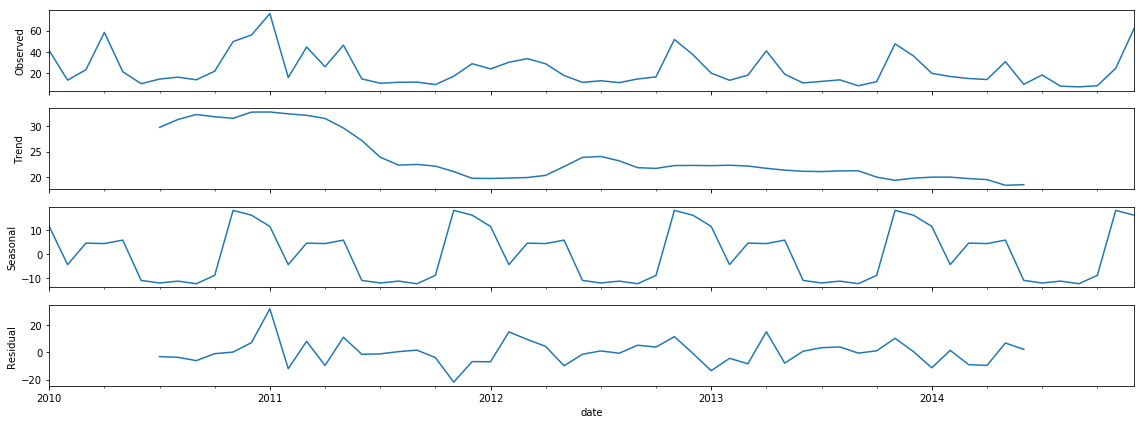

In [0]:
# Decomposing the data to check for Trends, Seasonality and Noise.
decomposition = sm.tsa.seasonal_decompose(grpd_df['Iws'])
fig = decomposition.plot()
plt.show()

- Interesting to observe the general Trend of Cumulated wind speed is going down starting from mid of 2011.

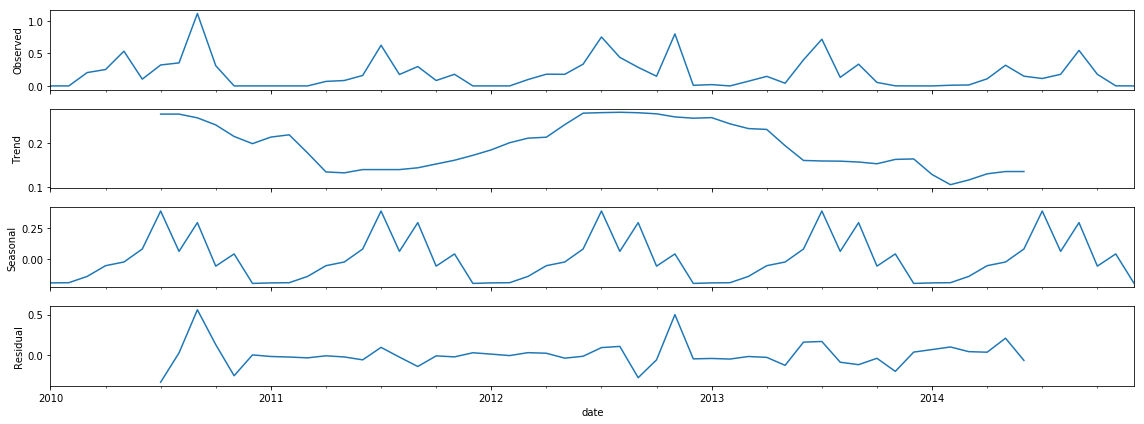

In [0]:
# Decomposing the data to check for Trends, Seasonality and Noise.
decomposition = sm.tsa.seasonal_decompose(grpd_df['Ir'])
fig = decomposition.plot()
plt.show()

# Building VAR (Vector Auto Regression) Model on the original data

In [0]:
# plt.plot(df['2010-01']['pm2.5'].isnull())
df['2010-01-02']['pm2.5'].mean()

145.95833333333334

In [0]:
df['pm2.5'].fillna(method='ffill', inplace=True)
df['pm2.5'].fillna(value=df['2010-01-02']['pm2.5'].mean(), inplace=True)
df.head()

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
date,,,,,,,,
2010-01-01 00:00:00,145.958333,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,145.958333,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,145.958333,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,145.958333,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,145.958333,-20,-12.0,1018.0,NW,12.97,0,0


In [0]:
df.isnull().sum()

pm2.5    0
DEWP     0
TEMP     0
PRES     0
cbwd     0
Iws      0
Is       0
Ir       0
dtype: int64

In [0]:
le = LabelEncoder()
df['cbwd'] = le.fit_transform(df['cbwd'])
df.head()

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
date,,,,,,,,
2010-01-01 00:00:00,145.958333,-21,-11.0,1021.0,1,1.79,0,0
2010-01-01 01:00:00,145.958333,-21,-12.0,1020.0,1,4.92,0,0
2010-01-01 02:00:00,145.958333,-21,-11.0,1019.0,1,6.71,0,0
2010-01-01 03:00:00,145.958333,-21,-14.0,1019.0,1,9.84,0,0
2010-01-01 04:00:00,145.958333,-20,-12.0,1018.0,1,12.97,0,0


In [0]:
df = pd.read_hdf(r"/content/gdrive/My Drive/Colab Notebooks/Time Series/final_data.h5", key='df')
backp_df = df.copy()

In [0]:
df = backp_df.copy().resample('D').mean()

# Split data into train and validation set
train = df[:int(0.7*(len(df)))]
valid = df[int(0.7*(len(df))):]

In [0]:
sc = StandardScaler()
sc.fit(d_train)
train = pd.DataFrame(sc.transform(d_train), columns=df.columns, index=d_train.index)
valid = pd.DataFrame(sc.transform(d_valid), columns=df.columns, index=d_valid.index)

In [0]:
# hdf = pd.HDFStore(r"/content/gdrive/My Drive/Colab Notebooks/Time Series/final_data.h5", mode='w')
# hdf['df'] = df
# hdf['train'] = train
# hdf['valid'] = valid
# print(hdf.keys())
# hdf.close()

['/df', '/train', '/valid']


In [0]:
# df = pd.read_hdf(r"/content/gdrive/My Drive/Colab Notebooks/Time Series/final_data.h5", key='df')
# train = pd.read_hdf(r"/content/gdrive/My Drive/Colab Notebooks/Time Series/final_data.h5", key='train')
# valid = pd.read_hdf(r"/content/gdrive/My Drive/Colab Notebooks/Time Series/final_data.h5", key='valid')

In [122]:
# Vector Autoregressive Moving Average with eXogenous regressors model (VARMAX)
model = sm.tsa.VARMAX(train, order=(5, 0), trend='c')
model_result = model.fit(maxiter=1000, disp=False)
model_result.summary()

Dep. Variable:,"['pm2.5', 'DEWP', 'TEMP', 'PRES', 'cbwd', 'Iws', 'Is', 'Ir']",No. Observations:,1278
Model:,VAR(5),Log Likelihood,-7347.044
,+ intercept,AIC,15422.088
Date:,"Tue, 09 Jul 2019",BIC,17297.799
Time:,08:09:27,HQIC,16126.456
Sample:,01-01-2010,,
,- 07-01-2013,,
Covariance Type:,opg,,
Ljung-Box (Q):,"33.39, 65.13, 47.96, 53.05, 43.18, 47.47, 11.81, 29.17",Jarque-Bera (JB):,"300.16, 169.49, 13.62, 33.21, 23.74, 18301.59, 3431461.88, 694454.24"
Prob(Q):,"0.76, 0.01, 0.18, 0.08, 0.34, 0.19, 1.00, 0.90",Prob(JB):,"0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00"
Heteroskedasticity (H):,"1.02, 1.10, 0.87, 0.92, 1.01, 0.46, 0.31, 1.25",Skew:,"0.61, -0.61, -0.02, -0.22, -0.11, 3.00, 13.64, 8.04"


In [132]:
%%time
trends=['n','c','t','ct']
for i in range(1,6):
    time_d = datetime.now()
    trend = random.choice(trends)
    
    print('='*80)
    print(f'Processing Parameters - i: "{i}" and trend: "{trend}"')
    
    model = sm.tsa.VARMAX(train, order=(i,0), trend=trend)
    model_result = model.fit(maxiter=1000, disp=False)
    
    print('Order = ', i)
    print('AIC: ', model_result.aic)
    print('BIC: ', model_result.bic)
    print('HQIC: ', model_result.hqic)
    print(f'===> Time Taken: {datetime.now() - time_d}')

Processing Parameters - i: "1" and trend: "c"
Order =  1
AIC:  15637.559091255742
BIC:  16194.08866782899
HQIC:  15846.547529887792
===> Time Taken: 0:02:11.112277
Processing Parameters - i: "2" and trend: "c"
Order =  2
AIC:  15384.264708101538
BIC:  16270.589589310785
HQIC:  15717.098147404433
===> Time Taken: 0:03:15.157507
Processing Parameters - i: "3" and trend: "t"
Order =  3
AIC:  15596.618062803682
BIC:  16812.738248648926
HQIC:  16053.296502777419
===> Time Taken: 0:04:11.332219
Processing Parameters - i: "4" and trend: "t"
Order =  4
AIC:  15610.970148552206
BIC:  17156.885639033448
HQIC:  16191.493589196787
===> Time Taken: 0:08:45.147848
Processing Parameters - i: "5" and trend: "t"
Order =  5
AIC:  15661.09400390849
BIC:  17536.804799025733
HQIC:  16365.462445223917
===> Time Taken: 0:14:57.877419
CPU times: user 40min 51s, sys: 24min 42s, total: 1h 5min 34s
Wall time: 33min 20s


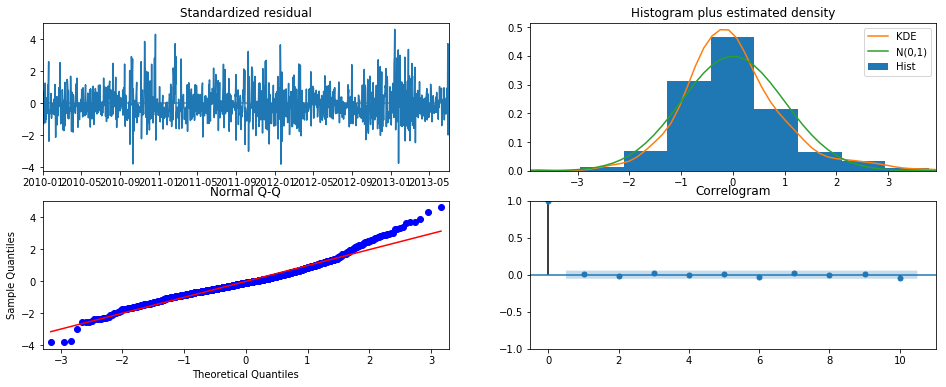

In [133]:
model = sm.tsa.VARMAX(train, order=(2,0), trend=trend)
model_result = model.fit(maxiter=1000, disp=False)
model_result.plot_diagnostics()
plt.show()

In [0]:
predictions = model_result.forecast(steps=len(valid))

In [135]:
# converting predictions to dataframe
var_pred = pd.DataFrame(predictions, columns=df.columns)

#check rmse
for i in df.columns:
    print('RMSE value for', i, 'is : ', np.sqrt(mean_squared_error(var_pred[i], valid[i])))

RMSE value for pm2.5 is :  0.9957580606161868
RMSE value for DEWP is :  0.981880481537895
RMSE value for TEMP is :  0.8841915334651451
RMSE value for PRES is :  0.942784011785283
RMSE value for cbwd is :  0.9112192420759594
RMSE value for Iws is :  0.9656855282988452
RMSE value for Is is :  0.5872590859828002
RMSE value for Ir is :  0.8612870994023238


In [0]:
# Vector Auto Regression (VAR) Model
# model = VAR(endog=train.values)
# model_fit = model.fit()

# # make forecast for the length of validation set
# predictions = model_fit.forecast(model_fit.y, steps=len(valid))

In [119]:
# converting predictions to dataframe
var_pred = pd.DataFrame(predictions, columns=df.columns)

#check rmse
for i in df.columns:
    print('RMSE value for', i, 'is : ', np.sqrt(mean_squared_error(var_pred[i], valid[i])))

RMSE value for pm2.5 is :  0.993229241723097
RMSE value for DEWP is :  0.9793571042832377
RMSE value for TEMP is :  0.8753258918530747
RMSE value for PRES is :  0.940336715527694
RMSE value for cbwd is :  0.9092467476147992
RMSE value for Iws is :  0.9674121292539815
RMSE value for Is is :  0.5875176211183392
RMSE value for Ir is :  0.8631990216738337


In [113]:
# Make final predictions
model = VAR(endog=df.values)
model_fit = model.fit()
yhat = model_fit.forecast(model_fit.y, steps=1)
print(yhat)

[[ 4.37105833e+01 -1.92465850e+01 -2.51050394e+00  1.03049282e+03
   1.39912333e+00  8.11041154e+01  3.65759900e-02  7.45123553e-03]]


In [0]:
from pylab import rcParams
rcParams['figure.figsize'] = 16, 6

def plot_pred_date(pred):
    pred = pd.DataFrame(sc.inverse_transform(pred), columns=df.columns, index=valid.index)
    temp = pd.DataFrame(sc.inverse_transform(train), columns=train.columns, index=train.index)
    
    for col in temp.columns:
        plt.plot(temp[col], 'r-', label='Actual Data')
        plt.plot(pred[col], 'b-', label='Predicted Data')
        plt.legend()
        plt.xlabel('Date')
        plt.ylabel(col)
        plt.title(f'Predicted {col} vs DateTime')
        plt.show()
        
    return


def plot_actual_pred(pred):
    pred = pd.DataFrame(sc.inverse_transform(pred), columns=df.columns, index=valid.index)
    temp = pd.DataFrame(sc.inverse_transform(valid), columns=valid.columns, index=valid.index)

    for col in temp.columns:
        plt.plot(temp[col], 'r-', label='Actual Data')
        plt.plot(pred[col], 'b-', label='Predicted Data')
        plt.legend()
        plt.xlabel('Date')
        plt.ylabel(col)
        plt.title(f'Actual {col} vs Predicted {col}')
        plt.show()
        
    return

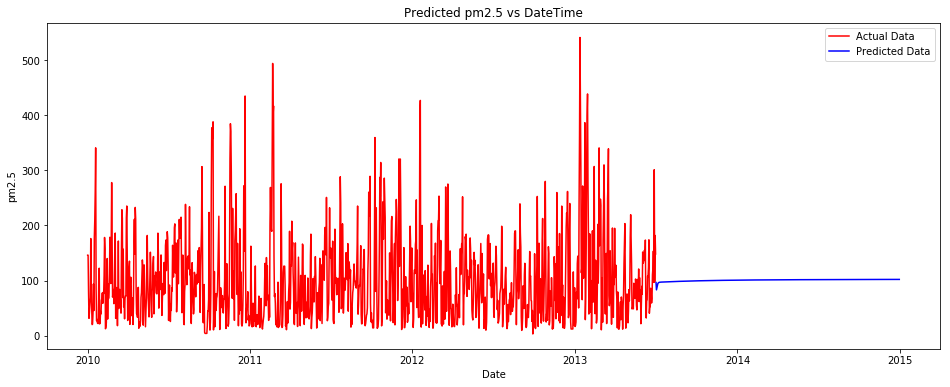

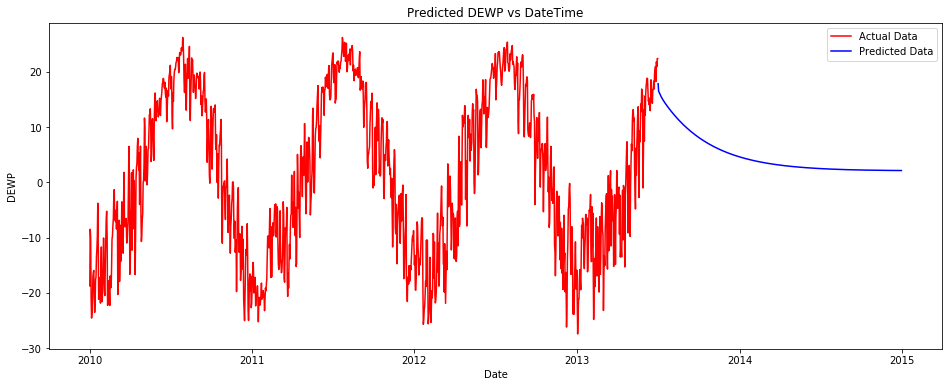

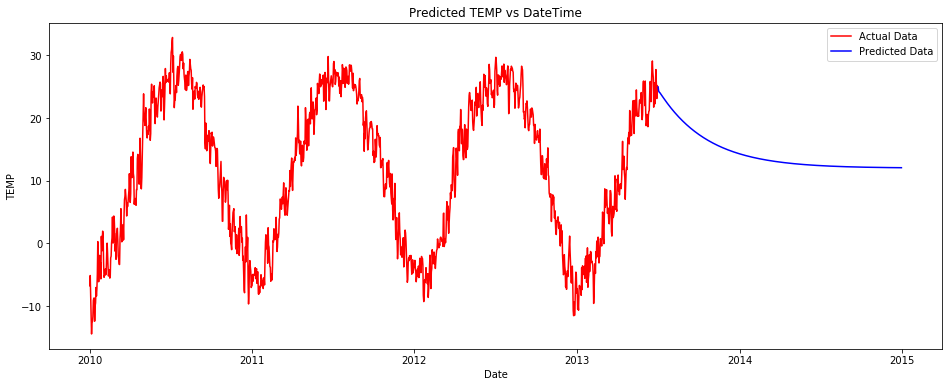

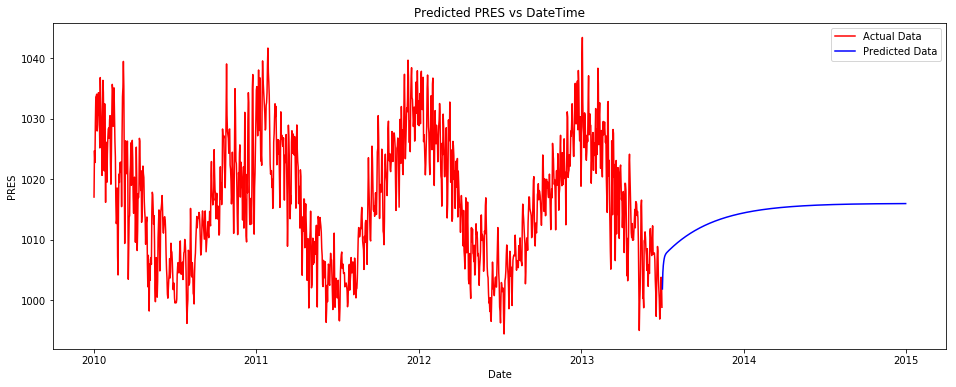

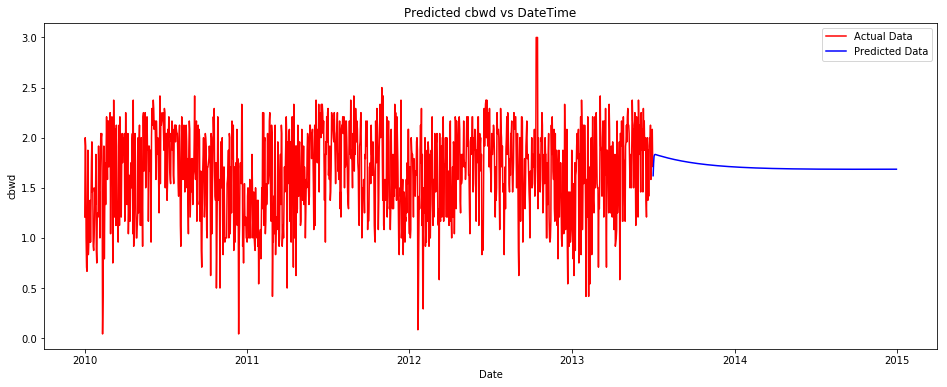

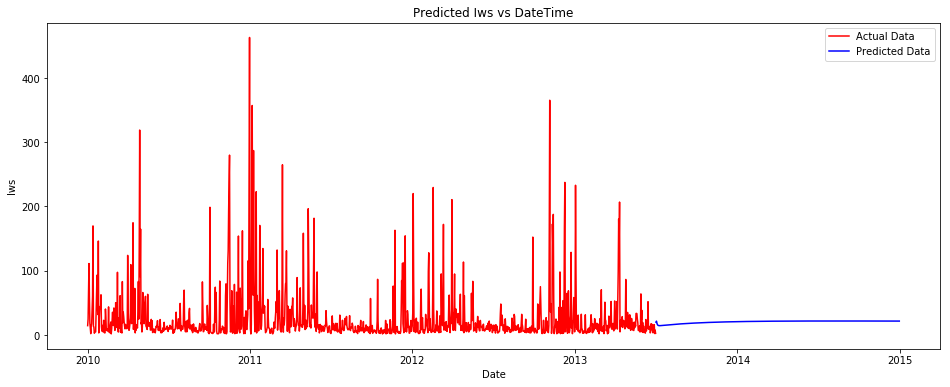

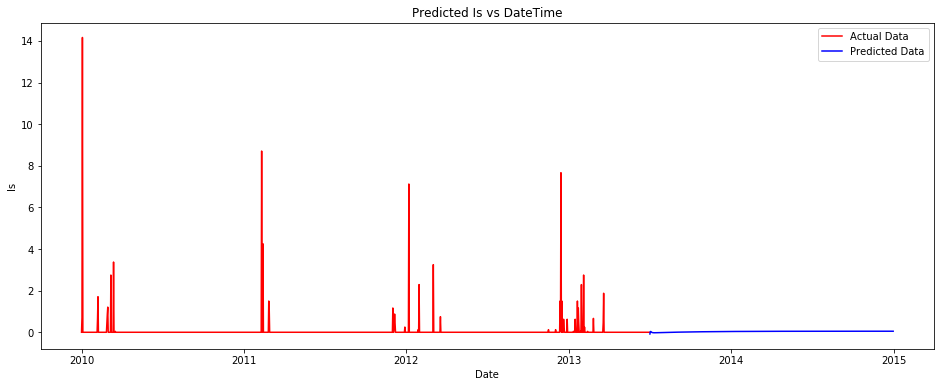

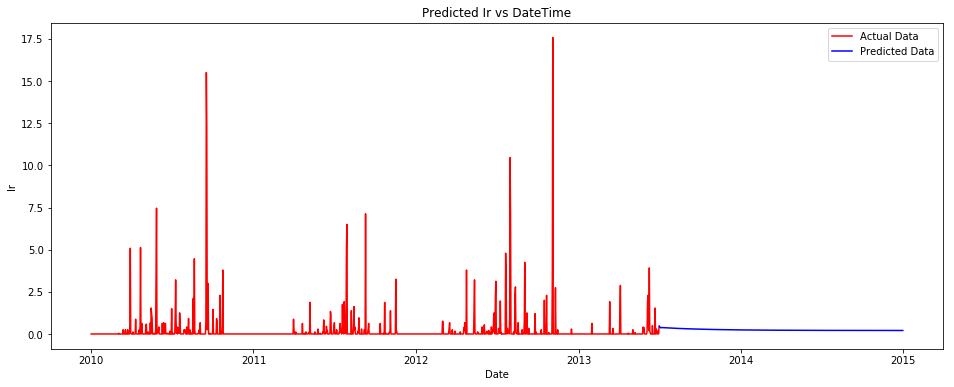

In [136]:
plot_pred_date(var_pred)

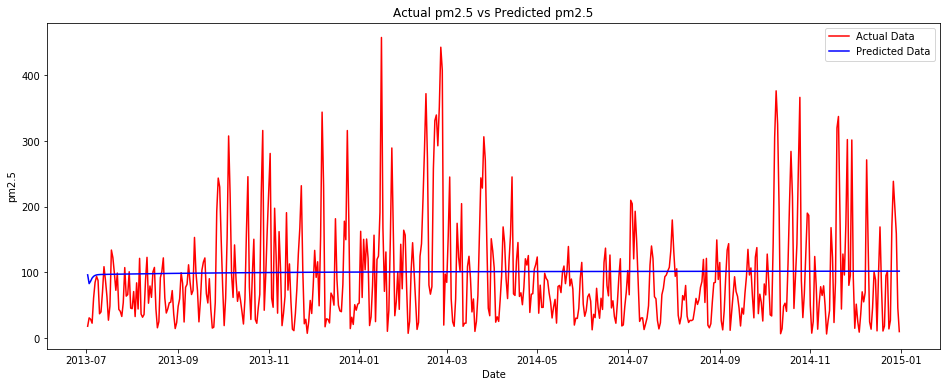

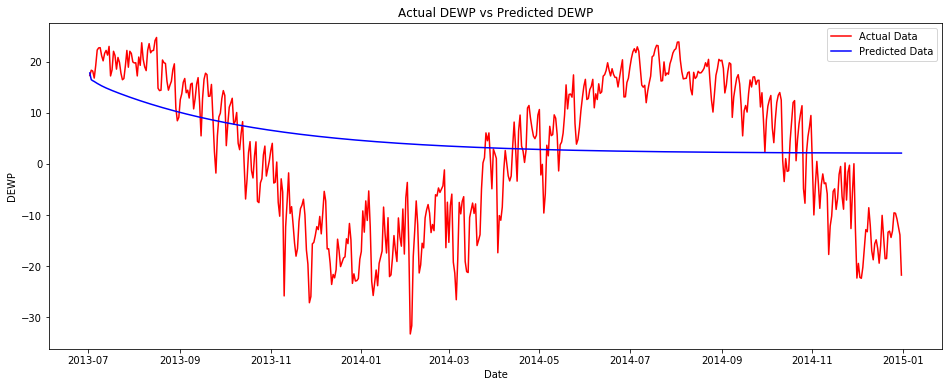

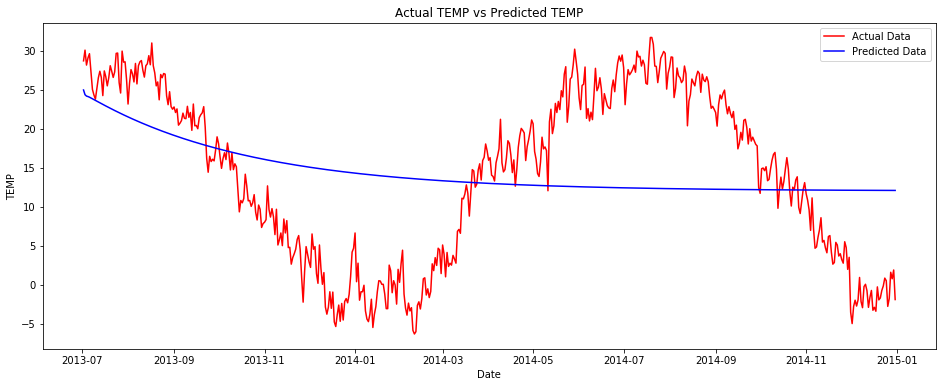

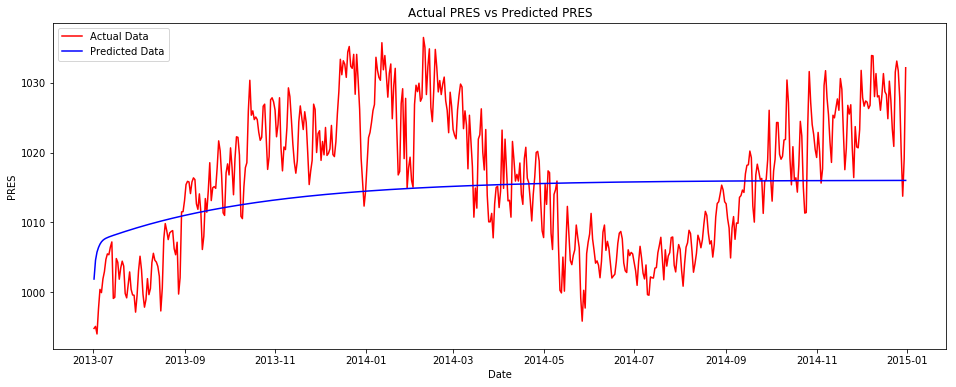

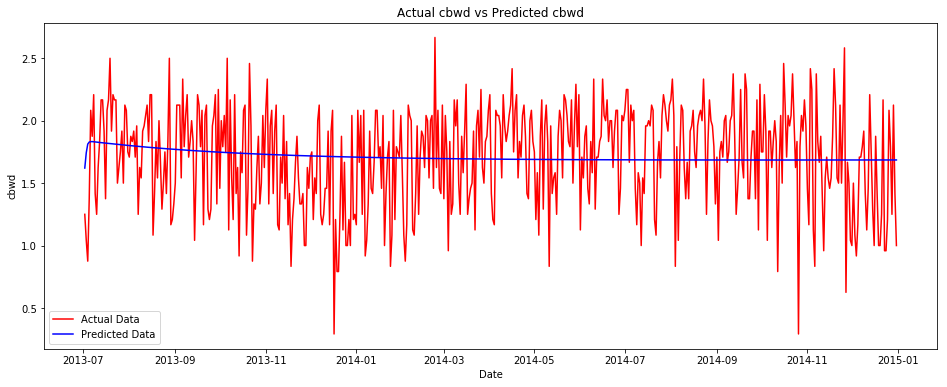

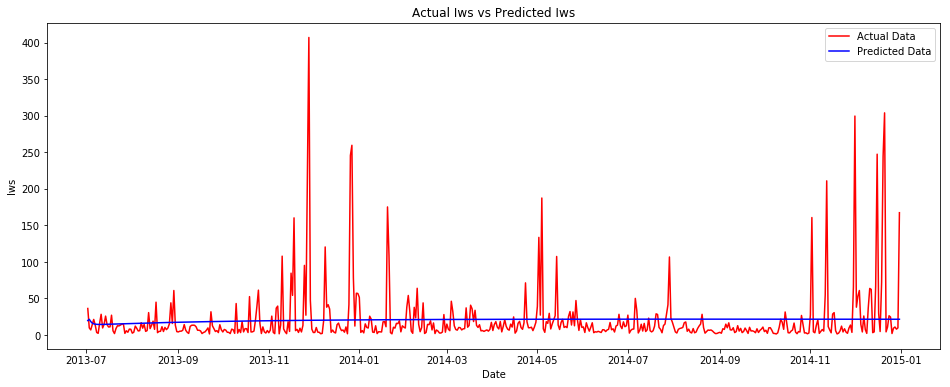

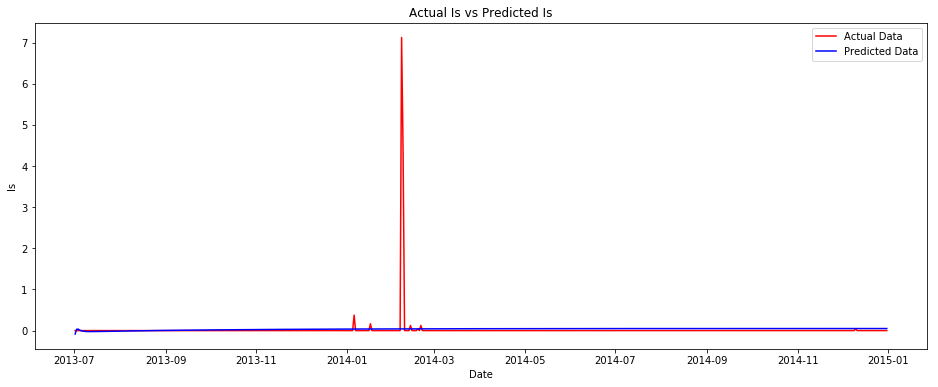

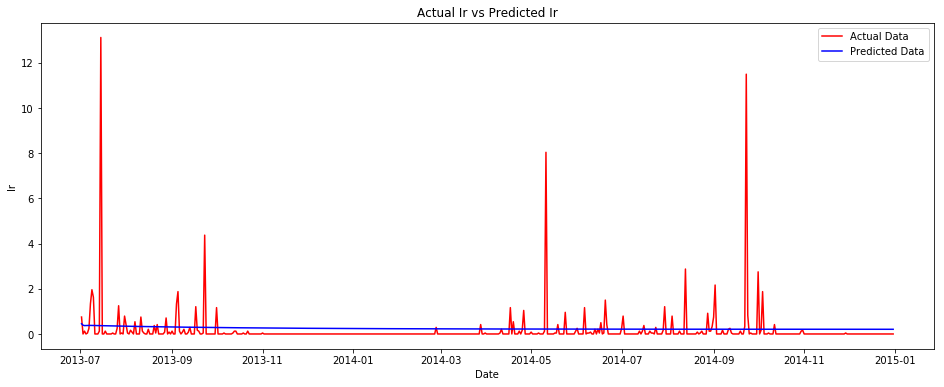

In [137]:
plot_actual_pred(var_pred)

- VAR  (Vector Auto Regressive) Model is not performing that well as seen from the plots above.
- The Model is unable to extract the Trend/Seasonality of variables like Temperature.

# Building LSTM Model on the original data

In [0]:
df = backp_df.copy().resample('D').mean()

# Split data into train and validation set
d_train = df[:int(0.7*(len(df)))]
d_valid = df[int(0.7*(len(df))):]

In [0]:
sc = StandardScaler()
sc.fit(d_train)
train = pd.DataFrame(sc.transform(d_train), columns=df.columns, index=d_train.index)
valid = pd.DataFrame(sc.transform(d_valid), columns=df.columns, index=d_valid.index)

In [0]:
n_input = len(train.columns)
n_features= len(train.columns)
generator = TimeseriesGenerator(train.values, train.values, length=n_input, batch_size=10)
test_data = np.vstack((train[-n_input:], valid.values))
valid_generator = TimeseriesGenerator(test_data, test_data, length=n_input, batch_size=len(test_data))

In [94]:
lstm_model = Sequential()
lstm_model.add(LSTM(500, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(100, activation='relu'))
lstm_model.add(Dense(8))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 8, 500)            1018000   
_________________________________________________________________
lstm_16 (LSTM)               (None, 200)               560800    
_________________________________________________________________
dense_13 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 808       
Total params: 1,599,708
Trainable params: 1,599,708
Non-trainable params: 0
_________________________________________________________________


In [95]:
lstm_model.fit_generator(generator,epochs=40)

Epoch 1/40
127/127 [==============================] - 9s 69ms/step - loss: 0.7044
Epoch 2/40
127/127 [==============================] - 6s 46ms/step - loss: 0.6383
Epoch 3/40
127/127 [==============================] - 6s 46ms/step - loss: 0.6121
Epoch 4/40
127/127 [==============================] - 6s 45ms/step - loss: 0.5918
Epoch 5/40
127/127 [==============================] - 6s 45ms/step - loss: 0.5548
Epoch 6/40
127/127 [==============================] - 6s 45ms/step - loss: 0.5480
Epoch 7/40
127/127 [==============================] - 6s 45ms/step - loss: 0.5500
Epoch 8/40
127/127 [==============================] - 6s 45ms/step - loss: 0.5300
Epoch 9/40
127/127 [==============================] - 6s 45ms/step - loss: 0.5078
Epoch 10/40
127/127 [==============================] - 6s 46ms/step - loss: 0.4989
Epoch 11/40
127/127 [==============================] - 6s 45ms/step - loss: 0.4879
Epoch 12/40
127/127 [==============================] - 6s 45ms/step - loss: 0.4697
Epoch 13/40
1

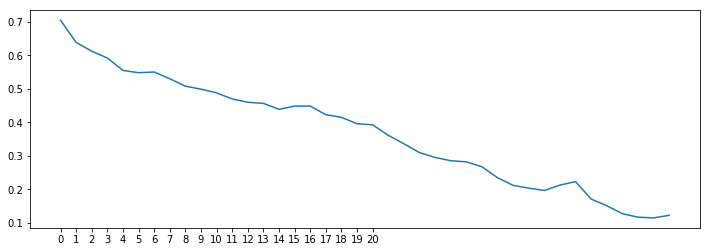

In [96]:
losses_lstm = lstm_model.history.history['loss']

plt.figure(figsize=(12,4))
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [0]:
lstm_predictions_scaled = list()

batch = train[-n_input:]
current_batch = batch.values.reshape((1, n_input, n_features))

for i in range(len(valid)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]], axis=1)

In [98]:
predictions = lstm_model.predict_generator(valid_generator)
predictions.shape, valid.shape

((548, 8), (548, 8))

In [102]:
# converting predictions to dataframe
lstm_pred = pd.DataFrame(predictions, columns=df.columns)

#check rmse
for i in df.columns:
    try:
        print('RMSE value for', i, 'is : ', np.sqrt(mean_squared_error(lstm_pred[i], valid[i])))
    except Exception as err:
        print(i, err)

RMSE value for pm2.5 is :  0.8986797610166349
RMSE value for DEWP is :  0.39525104950535106
RMSE value for TEMP is :  0.21264219060262107
RMSE value for PRES is :  0.41931010128975477
RMSE value for cbwd is :  1.0300892665382009
RMSE value for Iws is :  0.9661345412224759
RMSE value for Is is :  0.6565948850602646
RMSE value for Ir is :  1.0753303592694012


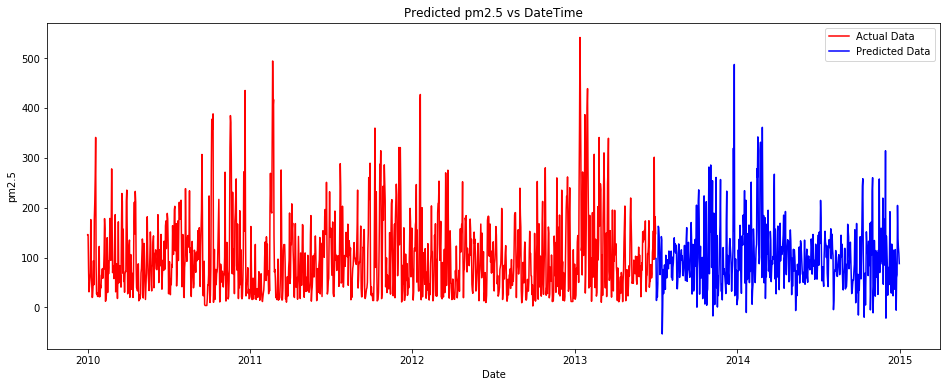

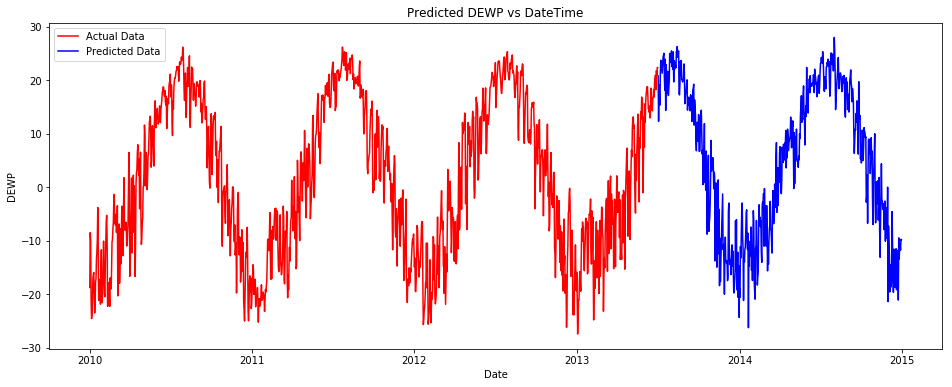

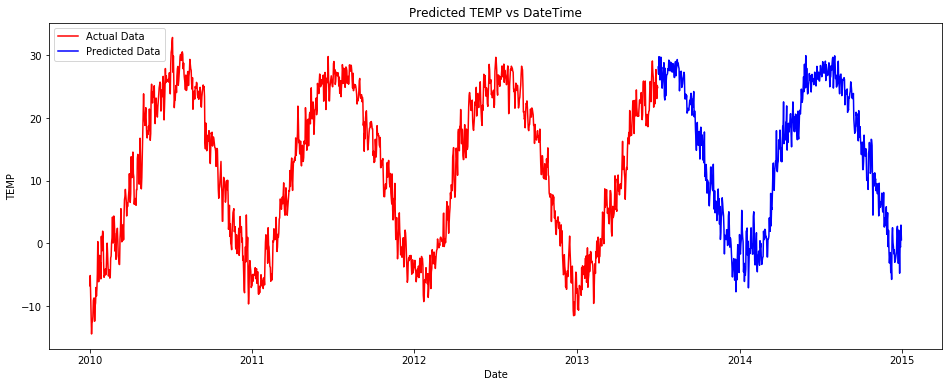

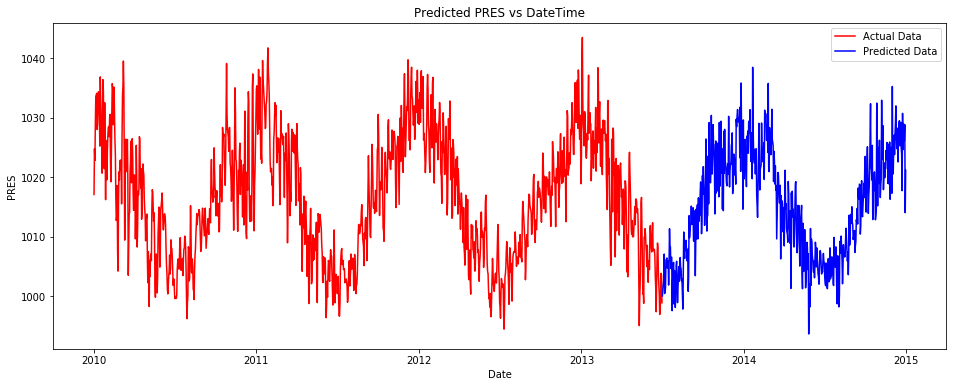

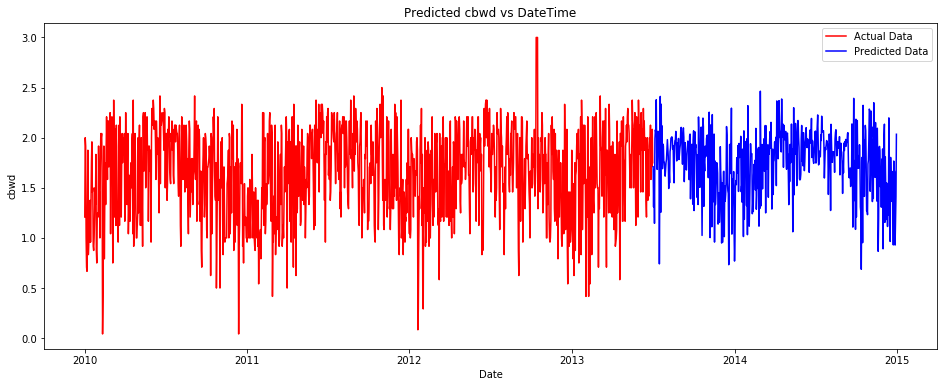

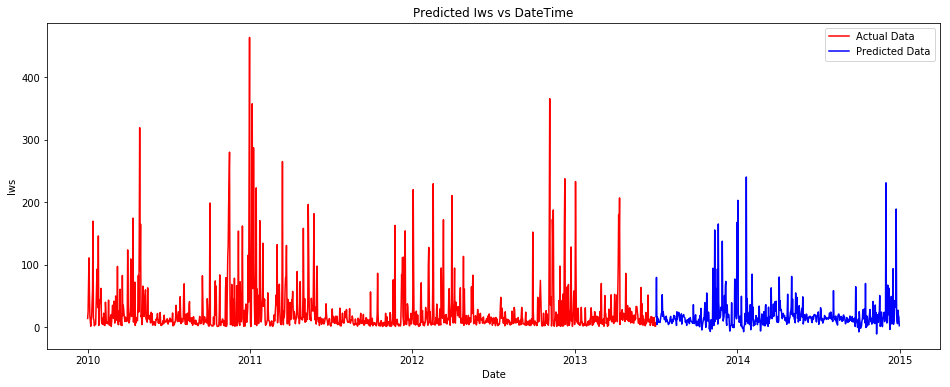

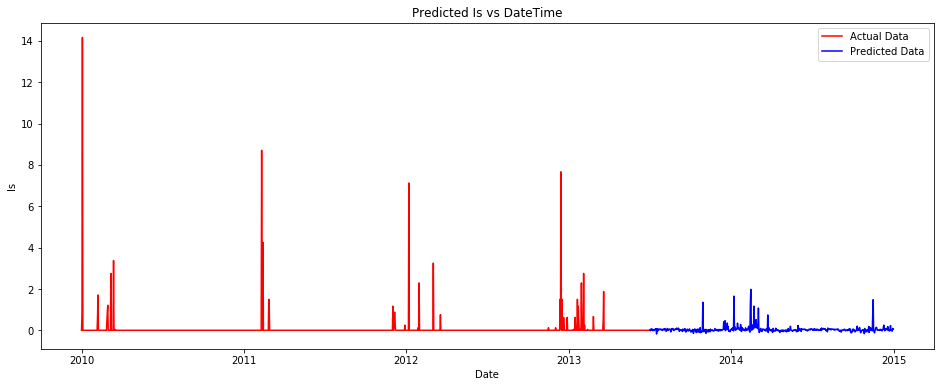

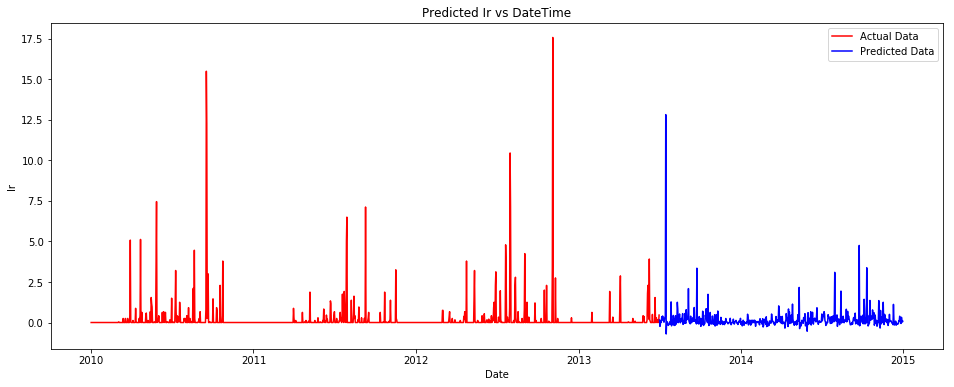

In [107]:
plot_pred_date(lstm_pred)

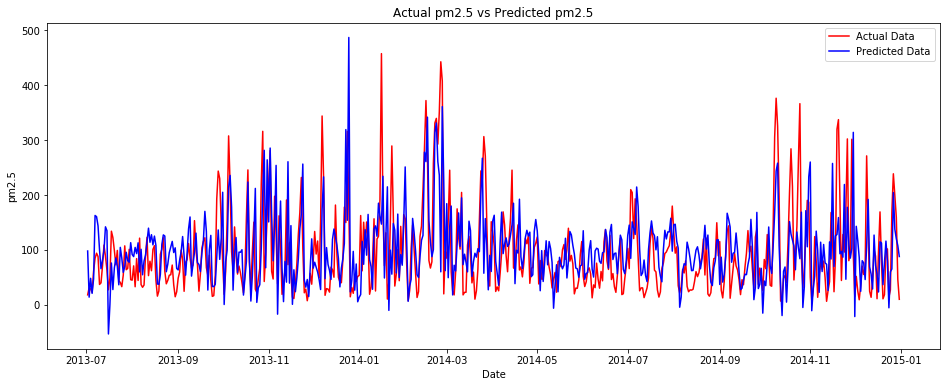

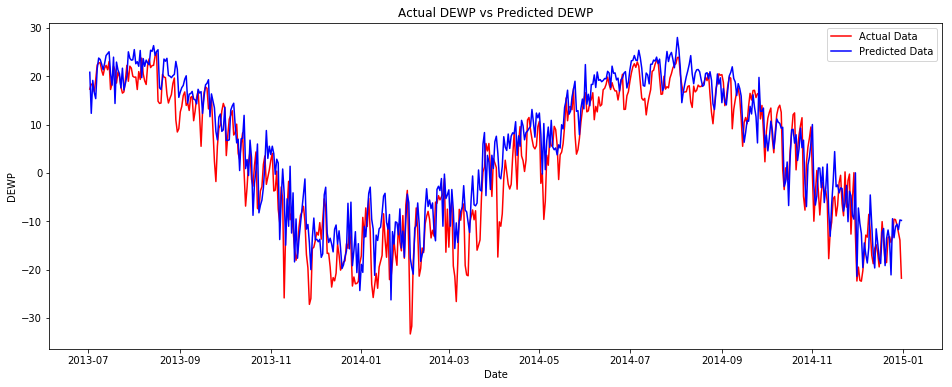

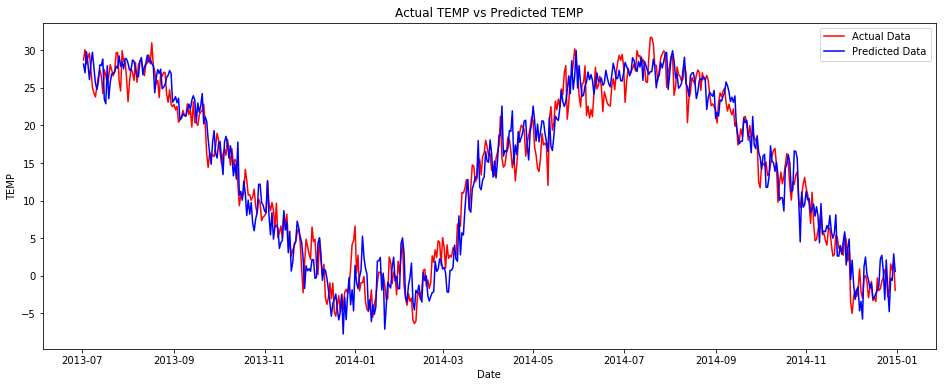

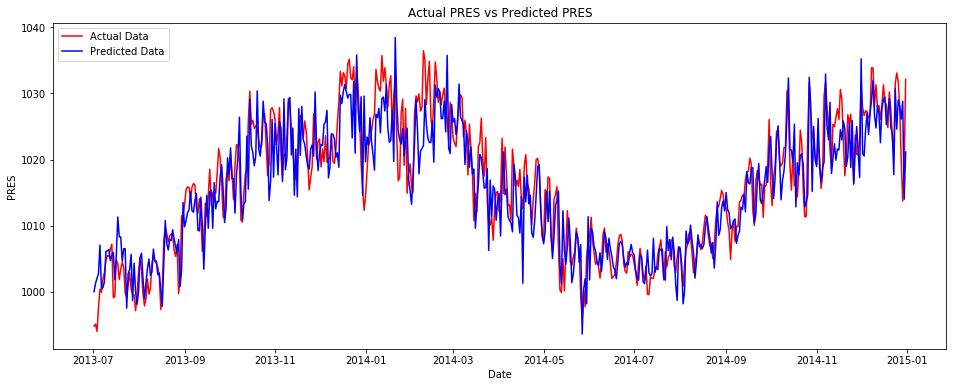

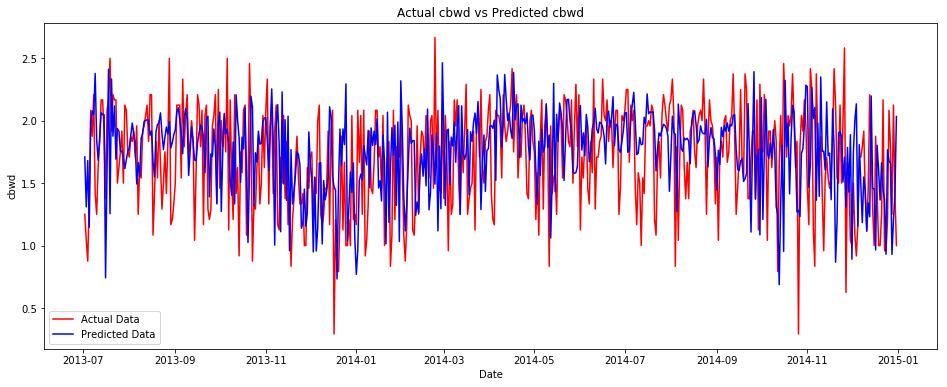

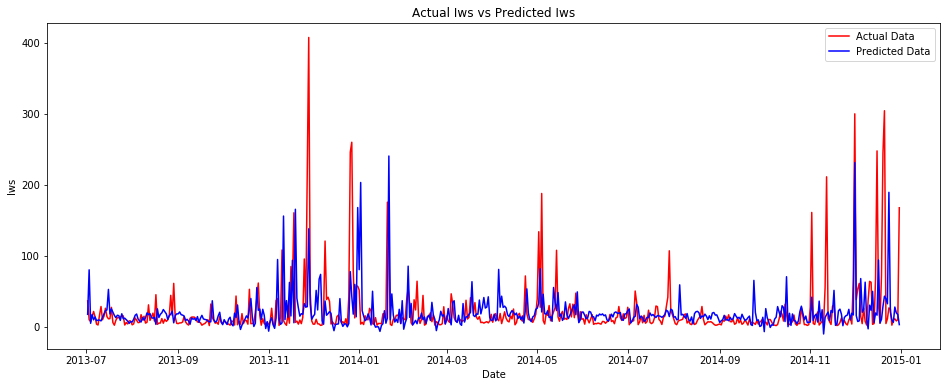

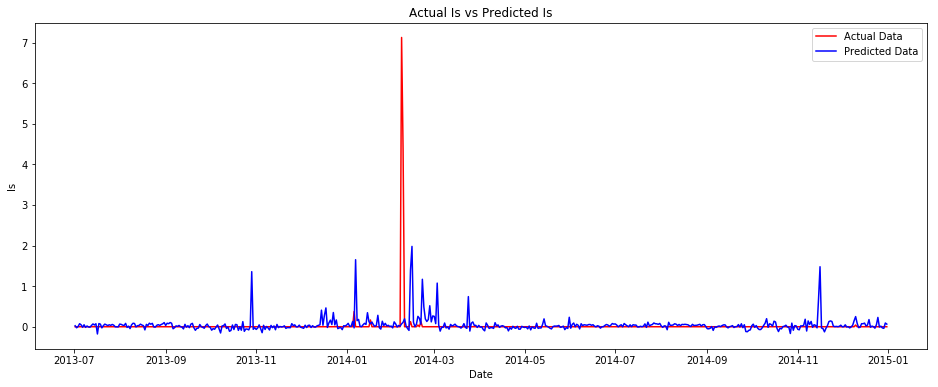

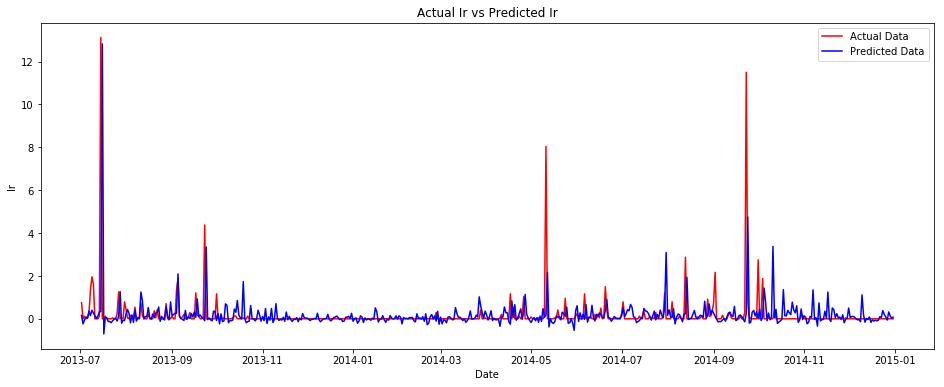

In [108]:
plot_actual_pred(lstm_pred)

- LSTM Model is performing the best out of all the techniques tried here.
- The Model is able to extract the underlying structure of the variables.

# Building Prophet Model on the original data

In [0]:
df = backp_df.copy().resample('D').mean()

# Split data into train and validation set
d_train = df[:int(0.7*(len(df)))]
d_valid = df[int(0.7*(len(df))):]

In [0]:
sc = StandardScaler()
sc.fit(d_train)
train = pd.DataFrame(sc.transform(d_train), columns=df.columns, index=d_train.index)
valid = pd.DataFrame(sc.transform(d_valid), columns=df.columns, index=d_valid.index)

In [140]:
train.head()

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
date,,,,,,,,
2010-01-01,0.602613,-1.429376,-1.566416,0.048582,-0.982894,-0.262916,-0.107891,-0.203359
2010-01-02,0.602613,-0.701916,-1.428320,0.804051,0.796207,-0.013389,1.055977,-0.203359
2010-01-03,-0.268717,-0.817245,-1.718676,0.611078,0.608933,1.091979,23.169459,-0.203359
2010-01-04,-0.885300,-1.580192,-1.970082,1.251584,-1.451079,2.056891,-0.107891,-0.203359
2010-01-05,-0.740890,-1.843379,-2.221488,1.678587,-2.106537,0.755702,-0.107891,-0.203359


In [141]:
df.columns

Index(['pm2.5', 'DEWP', 'TEMP', 'PRES', 'cbwd', 'Iws', 'Is', 'Ir'], dtype='object')

In [0]:
def get_prophet_prediction(df):
    time_d = datetime.now()
#     print(f'Processing Column: {df.drop("date").columns}...')
    
    prop_df = df.copy()
    prop_df.reset_index(inplace=True)
    prop_df.columns =['ds', 'y']

    prop = Prophet()
    prop.fit(prop_df)

    future = prop.make_future_dataframe(periods=len(valid), freq='H')
    pred = prop.predict(future)

    print(pred['yhat'].shape)
    print(f'Time Taken: {datetime.now() - time_d}')
    return pred['yhat'][-len(valid):]

In [143]:
%%time
# pred['yhat'].shape, df.shape
# pred[-len(valid):].shape, valid.shape

# np.array(df.columns) - np.array(['DEWP'])
prophet_preds = pd.DataFrame()
cols = df.columns.to_list()
for col in cols:
    rem_cols = cols.copy()
    rem_cols.remove(col)
    print(f'Processing Column: "{col}"...')
    print(rem_cols)
    prophet_preds[col] = get_prophet_prediction(train.drop(rem_cols, axis=1))

Processing Column: "pm2.5"...
['DEWP', 'TEMP', 'PRES', 'cbwd', 'Iws', 'Is', 'Ir']
(1826,)
Time Taken: 0:00:06.688487
Processing Column: "DEWP"...
['pm2.5', 'TEMP', 'PRES', 'cbwd', 'Iws', 'Is', 'Ir']
(1826,)
Time Taken: 0:00:07.139492
Processing Column: "TEMP"...
['pm2.5', 'DEWP', 'PRES', 'cbwd', 'Iws', 'Is', 'Ir']
(1826,)
Time Taken: 0:00:06.985171
Processing Column: "PRES"...
['pm2.5', 'DEWP', 'TEMP', 'cbwd', 'Iws', 'Is', 'Ir']
(1826,)
Time Taken: 0:00:06.773503
Processing Column: "cbwd"...
['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir']
(1826,)
Time Taken: 0:00:06.702221
Processing Column: "Iws"...
['pm2.5', 'DEWP', 'TEMP', 'PRES', 'cbwd', 'Is', 'Ir']
(1826,)
Time Taken: 0:00:06.713854
Processing Column: "Is"...
['pm2.5', 'DEWP', 'TEMP', 'PRES', 'cbwd', 'Iws', 'Ir']
(1826,)
Time Taken: 0:00:06.641031
Processing Column: "Ir"...
['pm2.5', 'DEWP', 'TEMP', 'PRES', 'cbwd', 'Iws', 'Is']
(1826,)
Time Taken: 0:00:06.677258
CPU times: user 1min 1s, sys: 24.6 s, total: 1min 26s
Wall time:

In [144]:
print(prophet_preds.shape, valid.shape)
prophet_preds.head()

(548, 8) (548, 8)


,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
1278,0.087306,1.260802,1.170076,-1.403411,0.735568,-0.530479,-0.115285,-0.039119
1279,0.086449,1.261084,1.169387,-1.404095,0.741275,-0.533745,-0.123310,-0.038385
1280,0.085970,1.261472,1.168737,-1.404996,0.746505,-0.536403,-0.130530,-0.036798
1281,0.085874,1.261964,1.168129,-1.406102,0.751210,-0.538413,-0.136912,-0.034402
1282,0.086162,1.262554,1.167569,-1.407399,0.755352,-0.539745,-0.142430,-0.031249


In [146]:
#check rmse
for i in df.columns:
    try:
        print('RMSE value for', i, 'is : ', np.sqrt(mean_squared_error(prophet_preds[i], valid[i])))
    except Exception as err:
        print(i, err)

RMSE value for pm2.5 is :  1.0217142915107071
RMSE value for DEWP is :  1.6797120928654006
RMSE value for TEMP is :  1.3496210685212926
RMSE value for PRES is :  1.5968550815090115
RMSE value for cbwd is :  1.0431094445529674
RMSE value for Iws is :  1.0175959809952562
RMSE value for Is is :  0.5958058657818264
RMSE value for Ir is :  0.9265096707157408


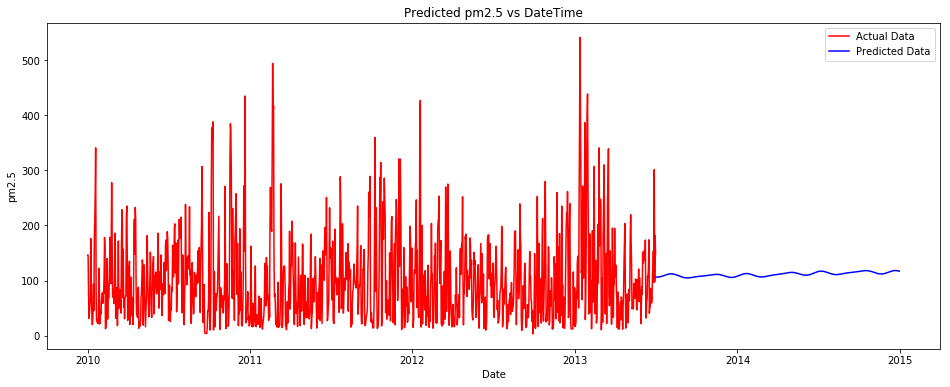

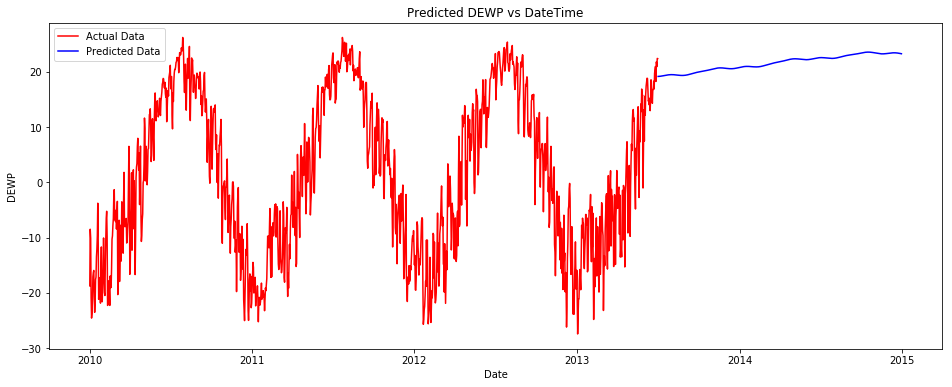

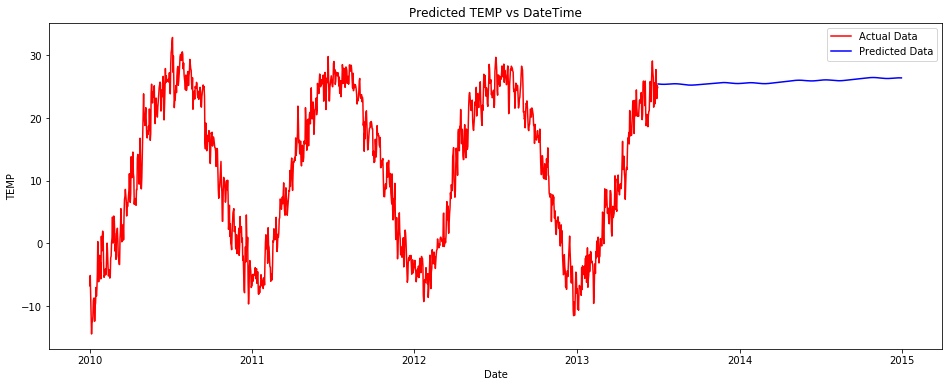

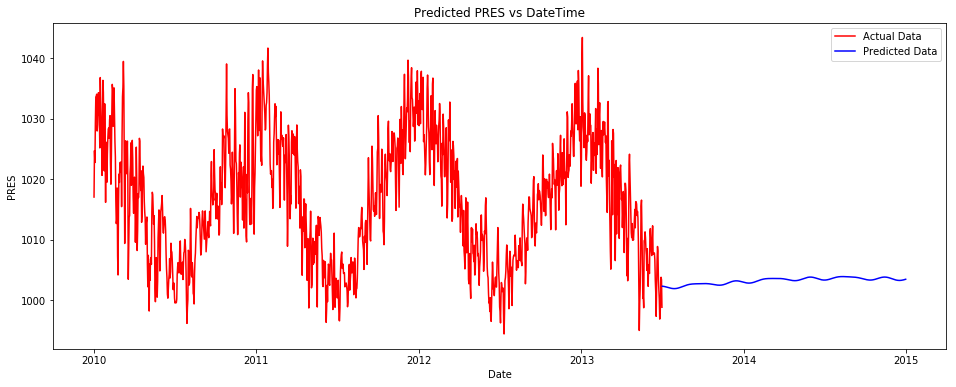

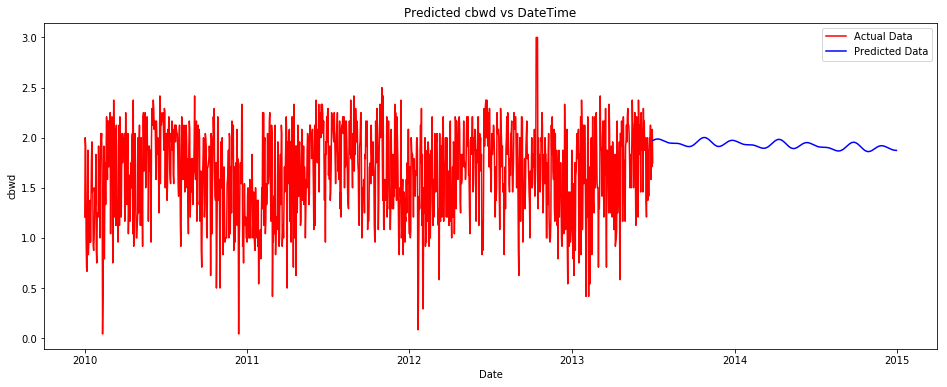

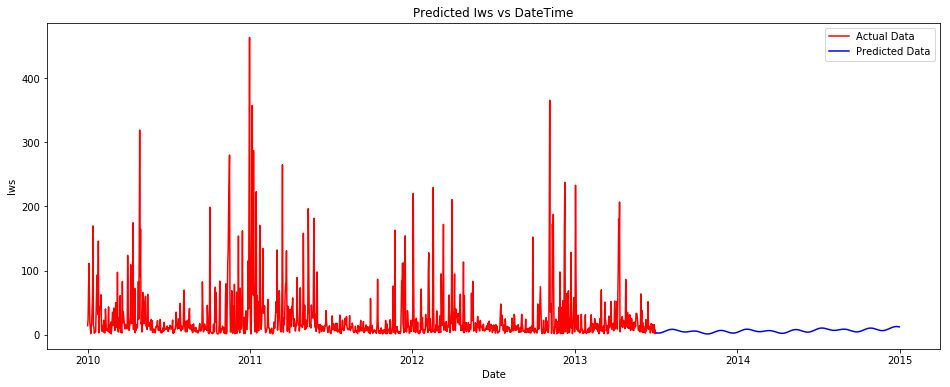

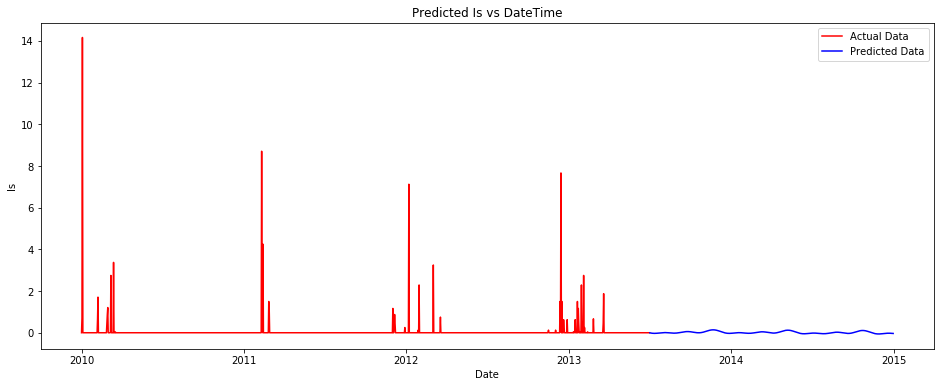

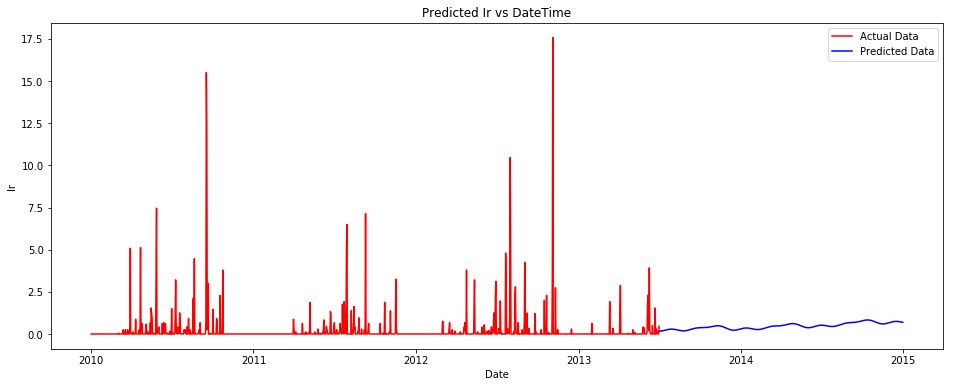

In [147]:
plot_pred_date(prophet_preds)

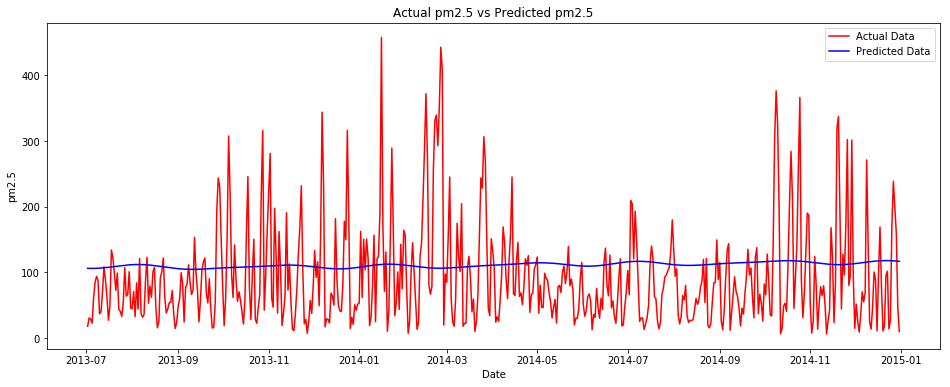

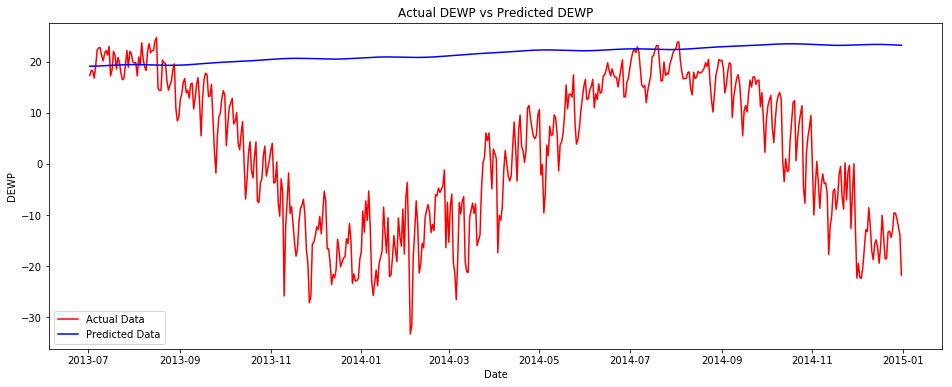

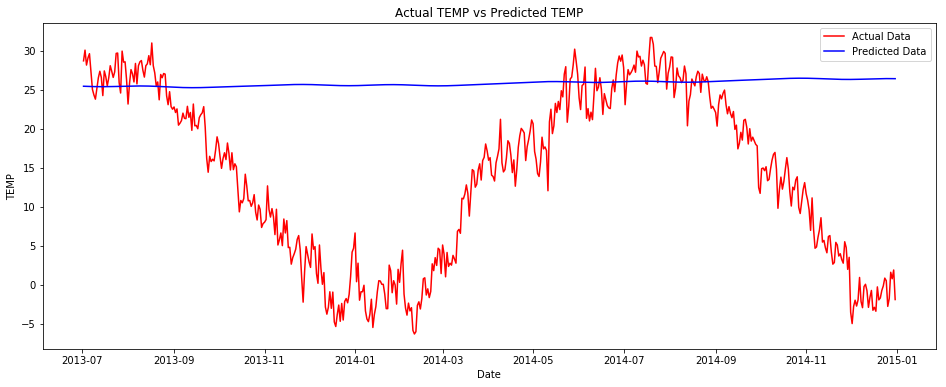

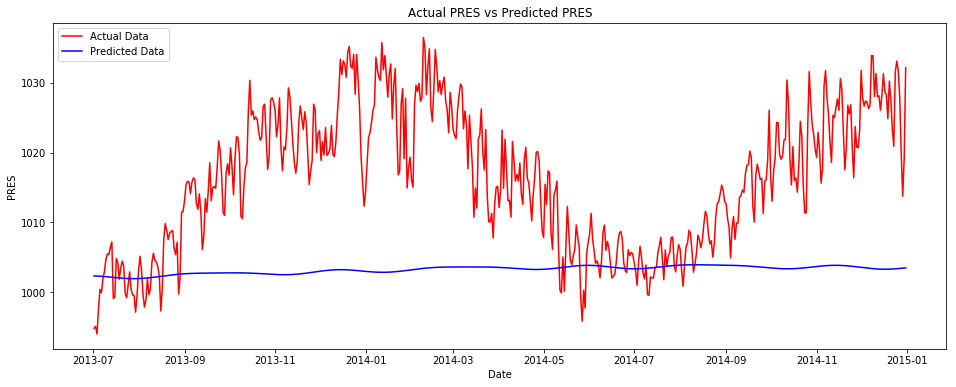

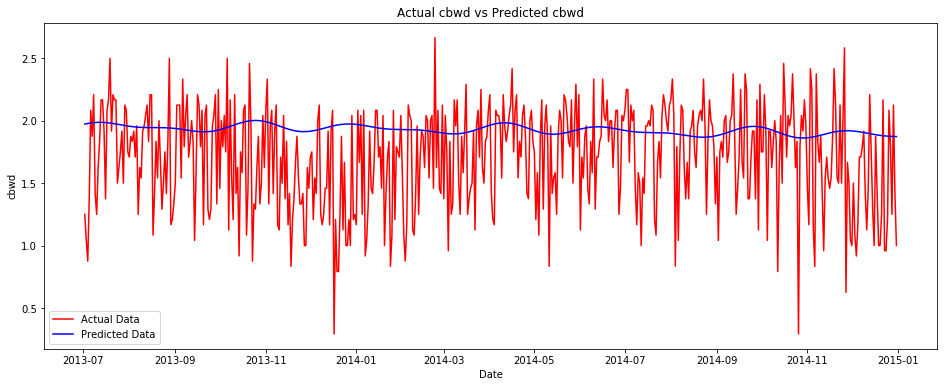

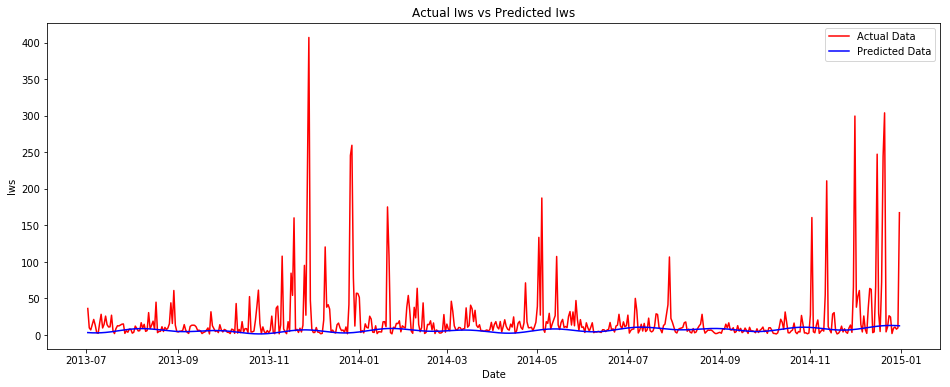

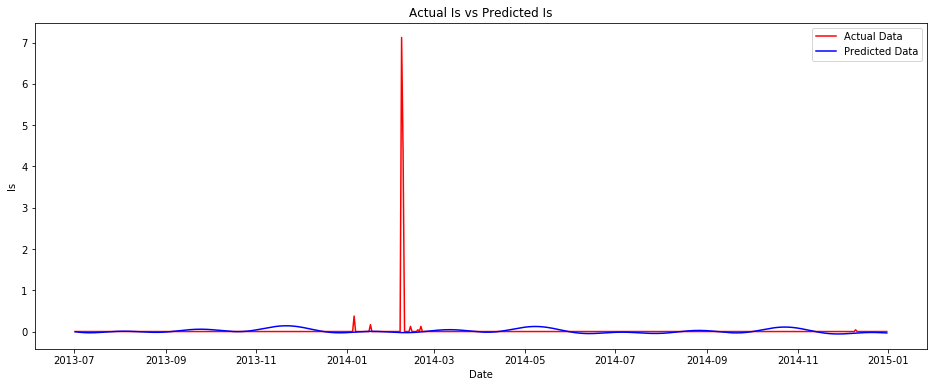

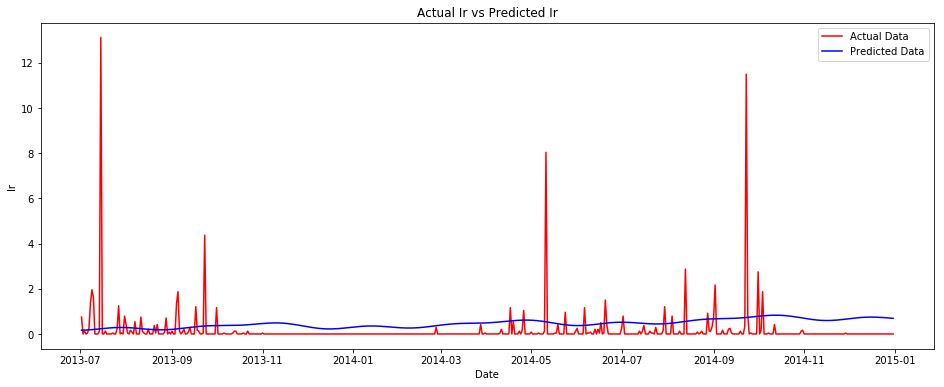

In [148]:
plot_actual_pred(prophet_preds)

- Prophet is not performing that well as seen from the plots above.
- The Model is unable to extract the Trend/Seasonality of variables like Temperature.

# Conclusion :-
- LSTM Model is able to extract the underlying structure and forecast data very similar to actual data. Out of the all the techniques used, this model is performing the best.
- Some interesting observations have been noted while performing EDA like a dip in PM2.5 levels in the year 2012. Reasons for the dip can be researched further to offer ways to reduce PM2.5 for future forecasts.
- The ML Problem can also be posed as a Regression problem and other Regression models can be used to forecast future values of individual variable using the others as features.

# References :-
- https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b
- https://www.analyticsvidhya.com/blog/2018/09/multivariate-time-series-guide-forecasting-modeling-python-codes/
- https://www.kaggle.com/cdabakoglu/time-series-forecasting-arima-lstm-prophet
- https://machinelearningmastery.com/time-series-datasets-for-machine-learning/